In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # "0, 1" for multiple

In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re

import h5py
from scipy.ndimage import zoom

#from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import normalized_root_mse as nrmse
#from skimage.metrics import peak_signal_noise_ratio as psnr

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
#import display_fns

import automap_fns #import automapRecon
import unrolling_fns

2024-12-12 15:01:19.296733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 15:01:20.059899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}

#plt.rc('font', **font)
plt.rc('font', size=9)

### Set mask parameters

## Importing fastMRI data and downsampling

The downsampled FastMRI data was saved externally to save processing time, it can be regenerated by uncommenting the following block of code

In [4]:
# loading previously downsampled fast MRI data
inputfile = 'data/fastmri/fastmri_75_64_25_val_all.npz'
data = np.load(inputfile)

In [5]:
ksp_fs_sc_all = data['ksp_fs_sc_all']
ksp_us_sc_all = data['ksp_us_sc_all']
img_gt_sc_all = data['img_gt_sc_all']

In [6]:
ksp_fs_sc_all.shape

(1, 75, 64, 25, 1378)

In [7]:
img_gt_sc_all.shape

(75, 64, 25, 1378)

In [8]:
# comment out unneeded code block below

#quick run to generate images at high/low SNR
noise_dB = np.array([60,70,80]) 
n_ex_cs = 3
n_ex_test = 3

#test run to generate manuscript plots
# noise_dB = np.arange(50,92,2)
# n_ex_cs = 3
# n_ex_test = 3

# #long run to generate manuscript plots
# noise_dB = np.arange(50,92,2)
# n_ex_cs = 20
# n_ex_test = 100

noise_dB_zero = noise_dB - 40

In [9]:
noise_dB_zero

array([20, 30, 40])

In [10]:
#loss_fn = 'perceptual'
loss_fn = 'mse'
# defining mask
R=2
calib_size=10
in_seed = 0
imSize = img_gt_sc_all[:,:,:,0].shape
mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)

mask_R2 = mask

mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

In [11]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/DisCorNet_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/DisCorNet_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'


In [12]:
#mdic = {"mask":mask}
#savemat("mask_R2_PD.mat",mdic)

In [13]:
lamda_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals = np.zeros((noise_dB.size,n_ex_cs))

In [14]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_cs):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k]
        volumeGTscaled = img_gt_sc_all[:,:,:,k]
        
        kspInput = awgn(kspTestScaled,noise_val,L=1)
        uskspace = applyMask(kspInput,mask)

        lamda_opt_vals[j,k] = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
        iter_opt_vals[j,k] = find_iter_mask(uskspace,volumeGTscaled, lamda_opt_vals[j,k], mps, show_plot=False)

lamda_opt = lamda_opt_vals.mean(axis=1)
iter_opt = iter_opt_vals.mean(axis=1)

/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in divide
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in cast
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')


In [15]:
nrmse_cs_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_amap_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_unroll_vals = np.zeros((noise_dB.size,n_ex_test))

ssim_cs_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_amap_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_unroll_vals = np.zeros((noise_dB.size,n_ex_test))

In [16]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_test):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k+n_ex_cs]
        volumeGTscaled = img_gt_sc_all[:,:,:,k+n_ex_cs]
        
        kspInput = awgn(kspTestScaled,noise_val,L=1)
        uskspace = applyMask(kspInput,mask)

    
        volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
        volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

        volcsrecon = ulfl1recon(uskspace,mask,lamda_opt[j],iter_opt[j],mps)

        amap_scale = 1
        unroll_scale = 1#1/8
        volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
        #volunrollrecon = np.roll(volunrollrecon,(1,1),axis=(0,2))
        volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
        volamaprecon = volamaprecon/amap_scale
        volamaprecon_mc = volamaprecon_mc/amap_scale

        mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

        volumeGTscaled[mask_metrics]=0
        volcsrecon[mask_metrics]=0
        volifftrecon[mask_metrics]=0
        volamaprecon[mask_metrics]=0
        volunrollrecon[mask_metrics]=0

        nrmse_cs_vals[j,k] = nrmse(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_ifft_vals[j,k] = nrmse(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_amap_vals[j,k] = nrmse(np.abs(volamaprecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_unroll_vals[j,k] = nrmse(np.abs(volunrollrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))

        ssim_cs_vals[j,k] = ssim(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_ifft_vals[j,k] = ssim(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_amap_vals[j,k] = ssim(np.abs(volamaprecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_unroll_vals[j,k] = ssim(np.abs(volunrollrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))



(1, 75, 64, 25)


2024-12-12 15:10:39.665181: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-12 15:10:39.665231: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2024-12-12 15:10:39.665240: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2024-12-12 15:10:39.665317: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-12-12 15:10:39.665339: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-12-12 15:10:39.665344: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14
2024-12-12 15:10:42.546250: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89751552 exceeds 10% of fre

(1, 75, 64, 25)
(1, 75, 64, 25)


/home/david/repos/Low_Field_MRI_Recon/metrics.py:38: RuntimeWarning: invalid value encountered in divide
  im1_mag_uint8 = (I_true * 255 / np.max(I_true)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:38: RuntimeWarning: invalid value encountered in cast
  im1_mag_uint8 = (I_true * 255 / np.max(I_true)).astype('uint8')


(1, 75, 64, 25)
(1, 75, 64, 25)
(1, 75, 64, 25)
(1, 75, 64, 25)
(1, 75, 64, 25)
(1, 75, 64, 25)


In [17]:
nrmse_cs = nrmse_cs_vals.mean(axis=1)
nrmse_ifft = nrmse_ifft_vals.mean(axis=1)
nrmse_amap = nrmse_amap_vals.mean(axis=1)
nrmse_unroll = nrmse_unroll_vals.mean(axis=1)

nrmse_cs_sd = nrmse_cs_vals.std(axis=1)
nrmse_ifft_sd = nrmse_ifft_vals.std(axis=1)
nrmse_amap_sd = nrmse_amap_vals.std(axis=1)
nrmse_unroll_sd = nrmse_unroll_vals.std(axis=1)

ssim_cs = ssim_cs_vals.mean(axis=1)
ssim_ifft = ssim_ifft_vals.mean(axis=1)
ssim_amap = ssim_amap_vals.mean(axis=1)
ssim_unroll = ssim_unroll_vals.mean(axis=1)

ssim_cs_sd = ssim_cs_vals.std(axis=1)
ssim_ifft_sd = ssim_ifft_vals.std(axis=1)
ssim_amap_sd = ssim_amap_vals.std(axis=1)
ssim_unroll_sd = ssim_unroll_vals.std(axis=1)

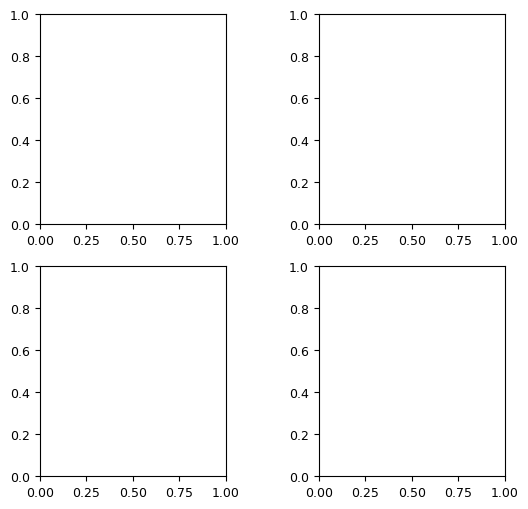

In [18]:
fig, ((ax1, ax3),(ax2, ax4)) = plt.subplots(2,2)
fig.set_size_inches(6,6)
fig.subplots_adjust(wspace=0.5)

In [19]:
line1 = ax1.plot(noise_dB_zero,nrmse_ifft, '-')
line2 = ax1.plot(noise_dB_zero,nrmse_cs, '-')
line3 = ax1.plot(noise_dB_zero,nrmse_amap, '-')
line4 = ax1.plot(noise_dB_zero,nrmse_unroll, '-')
#ax1.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax1.set(ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax1.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#plt.ylim(0,0.085)
#plt.xlim(55,90)
fill1 = ax1.fill_between(noise_dB_zero,nrmse_ifft-nrmse_ifft_sd,nrmse_ifft+nrmse_ifft_sd,alpha=0.25)
fill2 = ax1.fill_between(noise_dB_zero,nrmse_cs-nrmse_cs_sd,nrmse_cs+nrmse_cs_sd,alpha=0.25)
fill3 = ax1.fill_between(noise_dB_zero,nrmse_amap-nrmse_amap_sd,nrmse_amap+nrmse_amap_sd,alpha=0.25)
fill4 = ax1.fill_between(noise_dB_zero,nrmse_unroll-nrmse_unroll_sd,nrmse_unroll+nrmse_unroll_sd,alpha=0.25)

step=10
ax1.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax1.set_yticks([0,0.05,0.1])

line1 = ax3.plot(noise_dB_zero,ssim_ifft, '-')
line2 = ax3.plot(noise_dB_zero,ssim_cs, '-')
line3 = ax3.plot(noise_dB_zero,ssim_amap, '-')
line4 = ax3.plot(noise_dB_zero,ssim_unroll, '-')
#ax3.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax3.set(ylabel='SSIM',
xlabel='Input SNR (dB)')
#ax1.set_xscale('log')
ax3.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled AI'])
#ax1.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#plt.ylim(0,0.085)
#plt.xlim(55,90)

fill1 = ax3.fill_between(noise_dB_zero,ssim_ifft-ssim_ifft_sd,ssim_ifft+ssim_ifft_sd,alpha=0.25)
fill2 = ax3.fill_between(noise_dB_zero,ssim_cs-ssim_cs_sd,ssim_cs+ssim_cs_sd,alpha=0.25)
fill3 = ax3.fill_between(noise_dB_zero,ssim_amap-ssim_amap_sd,ssim_amap+ssim_amap_sd,alpha=0.25)
fill4 = ax3.fill_between(noise_dB_zero,ssim_unroll-ssim_unroll_sd,ssim_unroll+ssim_unroll_sd,alpha=0.25)

step=10
ax3.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax3.set_yticks([0.8,0.9,1])

#plt.show()

#fig.savefig('export_figs/fastmri_noise_curves_R'+str(R)+'.pdf',bbox_inches='tight',dpi=300)

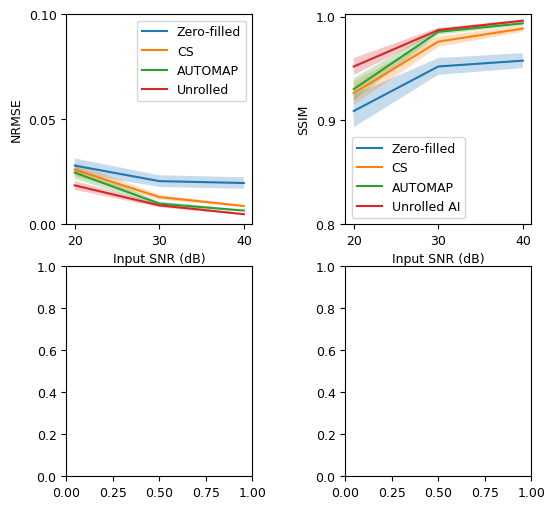

In [20]:
fig

## Low SNR

In [21]:
test_no = 125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l = 0
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [22]:
noise_val

60

In [23]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

(1, 75, 64, 25)


In [24]:
# # calculating SNR of input kspace (fully sampled)
# fs_recon = sp.ifft(kspInput,axes=[1,2,3])
# im_slice = fs_recon[0,:,32,:]
# fig=plt.figure()
# plt.imshow((abs(im_slice)))
# noise = np.std(np.abs(im_slice[0:8,10:20]))
# signal = np.mean(np.abs(im_slice[20:40,0:10]))
# snr=signal/noise
# print('SNR')
# snr

### Background Masked

In [25]:
model_real_dir

'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras'

In [26]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

vol1_low_R2 = vol1
vol2_low_R2 = vol2
vol3_low_R2 = vol3
vol4_low_R2 = vol4

#slc=10
#fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)
#fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

## High SNR

In [27]:
#test_no=125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l=-1
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [28]:
noise_val

80

In [29]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)

volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

(1, 75, 64, 25)


In [30]:
# calculating SNR of input kspace (fully sampled)
# fs_recon = sp.ifft(kspInput,axes=[1,2,3])
# im_slice = fs_recon[0,:,32,:]
# fig=plt.figure()
# plt.imshow((abs(im_slice)))
# noise = np.std(np.abs(im_slice[0:8,10:20]))
# signal = np.mean(np.abs(im_slice[20:40,0:10]))
# snr=signal/noise
# print('SNR')
# snr

### Background Masked

In [31]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

vol1_high_R2 = vol1
vol2_high_R2 = vol2
vol3_high_R2 = vol3
vol4_high_R2 = vol4

#slc=10
#fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

#fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

In [32]:
GT_R2 = volumeGTscaledmasked

In [33]:
#loss_fn = 'perceptual'
loss_fn = 'mse'
# defining mask
R=4
calib_size=10
in_seed = 0
imSize = img_gt_sc_all[:,:,:,0].shape
mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
mask_R4 = mask

mps = np.ones(ksp_fs_sc_all[:,:,:,:,0].shape,dtype=complex) #single coil

In [34]:
# if R==2:
#     if loss_fn=='perceptual':
#         unroll_model_pth = 'trained_models/Unrolling/DisCorNet_perceptual_R2.pth'
#         model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240523_percepmse/checkpoint/model.keras' #evenly weight perceptual and mse loss
#         model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240523_percepmse/checkpoint/model.keras'
#     elif loss_fn == 'mse':
#         unroll_model_pth = 'trained_models/Unrolling/DisCorNet_mse_R2.pth'
#         model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
#         model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
#     #model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_real_noise_bkgd_20230911/checkpoint/' #fast mri model
#     #model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20230911/checkpoint/'

    
# elif R==4:
#     if loss_fn == 'perceptual':
#         unroll_model_pth = 'trained_models/Unrolling/DisCorNet_perceptual_R4.pth'
#     elif loss_fn == 'mse':
#         unroll_model_pth = 'trained_models/Unrolling/DisCorNet_mse_R4.pth'
#     #AUTOMAP model
#     #model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240304/checkpoint/' #fast mri model
#     #model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240304/checkpoint/'
#     model_real_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
#     model_imag_dir = 'keras_amap/experiments/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'


In [35]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/DisCorNet_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/DisCorNet_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'


In [36]:
#mdic = {"mask":mask}
#savemat("mask_R2_PD.mat",mdic)

In [37]:
lamda_opt_vals = np.zeros((noise_dB.size,n_ex_cs))
iter_opt_vals = np.zeros((noise_dB.size,n_ex_cs))

In [ ]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_cs):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k]
        volumeGTscaled = img_gt_sc_all[:,:,:,k]
        
        kspInput = awgn(kspTestScaled,noise_val,L=1)
        uskspace = applyMask(kspInput,mask)

        lamda_opt_vals[j,k] = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
        iter_opt_vals[j,k] = find_iter_mask(uskspace,volumeGTscaled, lamda_opt_vals[j,k], mps, show_plot=False)

lamda_opt = lamda_opt_vals.mean(axis=1)
iter_opt = iter_opt_vals.mean(axis=1)

In [ ]:
nrmse_cs_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_amap_vals = np.zeros((noise_dB.size,n_ex_test))
nrmse_unroll_vals = np.zeros((noise_dB.size,n_ex_test))

ssim_cs_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_ifft_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_amap_vals = np.zeros((noise_dB.size,n_ex_test))
ssim_unroll_vals = np.zeros((noise_dB.size,n_ex_test))

In [ ]:
for j, noise_val in enumerate(noise_dB):
    for k in range(n_ex_test):
        kspTestScaled = ksp_fs_sc_all[:,:,:,:,k+n_ex_cs]
        volumeGTscaled = img_gt_sc_all[:,:,:,k+n_ex_cs]
        
        kspInput = awgn(kspTestScaled,noise_val,L=1)
        uskspace = applyMask(kspInput,mask)

    
        volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
        volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

        volcsrecon = ulfl1recon(uskspace,mask,lamda_opt[j],iter_opt[j],mps)

        amap_scale = 1
        unroll_scale = 1#1/8
        volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
        #volunrollrecon = np.roll(volunrollrecon,(1,1),axis=(0,2))
        volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
        volamaprecon = volamaprecon/amap_scale
        volamaprecon_mc = volamaprecon_mc/amap_scale

        mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

        volumeGTscaled[mask_metrics]=0
        volcsrecon[mask_metrics]=0
        volifftrecon[mask_metrics]=0
        volamaprecon[mask_metrics]=0
        volunrollrecon[mask_metrics]=0

        nrmse_cs_vals[j,k] = nrmse(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_ifft_vals[j,k] = nrmse(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_amap_vals[j,k] = nrmse(np.abs(volamaprecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        nrmse_unroll_vals[j,k] = nrmse(np.abs(volunrollrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))

        ssim_cs_vals[j,k] = ssim(np.abs(volcsrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_ifft_vals[j,k] = ssim(np.abs(volifftrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_amap_vals[j,k] = ssim(np.abs(volamaprecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))
        ssim_unroll_vals[j,k] = ssim(np.abs(volunrollrecon[:,:,1:]),np.abs(volumeGTscaled[:,:,1:]))



In [ ]:
nrmse_cs = nrmse_cs_vals.mean(axis=1)
nrmse_ifft = nrmse_ifft_vals.mean(axis=1)
nrmse_amap = nrmse_amap_vals.mean(axis=1)
nrmse_unroll = nrmse_unroll_vals.mean(axis=1)

nrmse_cs_sd = nrmse_cs_vals.std(axis=1)
nrmse_ifft_sd = nrmse_ifft_vals.std(axis=1)
nrmse_amap_sd = nrmse_amap_vals.std(axis=1)
nrmse_unroll_sd = nrmse_unroll_vals.std(axis=1)

ssim_cs = ssim_cs_vals.mean(axis=1)
ssim_ifft = ssim_ifft_vals.mean(axis=1)
ssim_amap = ssim_amap_vals.mean(axis=1)
ssim_unroll = ssim_unroll_vals.mean(axis=1)

ssim_cs_sd = ssim_cs_vals.std(axis=1)
ssim_ifft_sd = ssim_ifft_vals.std(axis=1)
ssim_amap_sd = ssim_amap_vals.std(axis=1)
ssim_unroll_sd = ssim_unroll_vals.std(axis=1)

In [ ]:
#ax2.clear()
#ax4.clear()

In [ ]:
line1 = ax2.plot(noise_dB_zero,nrmse_ifft, '-')
line2 = ax2.plot(noise_dB_zero,nrmse_cs, '-')
line3 = ax2.plot(noise_dB_zero,nrmse_amap, '-')
line4 = ax2.plot(noise_dB_zero,nrmse_unroll, '-')
#ax2.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax2.set(ylabel='NRMSE',
xlabel='Input SNR (dB)')
#ax2.set_xscale('log')
ax2.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled'])
#ax2.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#plt.ylim(0,0.085)
#plt.xlim(55,90)
fill1 = ax2.fill_between(noise_dB_zero,nrmse_ifft-nrmse_ifft_sd,nrmse_ifft+nrmse_ifft_sd,alpha=0.25)
fill2 = ax2.fill_between(noise_dB_zero,nrmse_cs-nrmse_cs_sd,nrmse_cs+nrmse_cs_sd,alpha=0.25)
fill3 = ax2.fill_between(noise_dB_zero,nrmse_amap-nrmse_amap_sd,nrmse_amap+nrmse_amap_sd,alpha=0.25)
fill4 = ax2.fill_between(noise_dB_zero,nrmse_unroll-nrmse_unroll_sd,nrmse_unroll+nrmse_unroll_sd,alpha=0.25)

step=10
ax2.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax2.set_yticks([0,0.05,0.1])

line1 = ax4.plot(noise_dB_zero,ssim_ifft, '-')
line2 = ax4.plot(noise_dB_zero,ssim_cs, '-')
line3 = ax4.plot(noise_dB_zero,ssim_amap, '-')
line4 = ax4.plot(noise_dB_zero,ssim_unroll, '-')
#ax4.set(title='Comparison of Reconstruction Methods, R='+str(R),
ax4.set(ylabel='SSIM',
xlabel='Input SNR (dB)')
#ax2.set_xscale('log')
ax4.legend(['Zero-filled', 'CS', 'AUTOMAP', 'Unrolled AI'])
#ax2.legend([line1, line2, line3], ['label1', 'label2', 'label3'])
#plt.ylim(0,0.085)
#plt.xlim(55,90)

fill1 = ax4.fill_between(noise_dB_zero,ssim_ifft-ssim_ifft_sd,ssim_ifft+ssim_ifft_sd,alpha=0.25)
fill2 = ax4.fill_between(noise_dB_zero,ssim_cs-ssim_cs_sd,ssim_cs+ssim_cs_sd,alpha=0.25)
fill3 = ax4.fill_between(noise_dB_zero,ssim_amap-ssim_amap_sd,ssim_amap+ssim_amap_sd,alpha=0.25)
fill4 = ax4.fill_between(noise_dB_zero,ssim_unroll-ssim_unroll_sd,ssim_unroll+ssim_unroll_sd,alpha=0.25)

step=10
ax4.set_xticks(np.arange(noise_dB_zero[0],noise_dB_zero[-1]+step,step))
ax4.set_yticks([0.8,0.9,1])

ax1.set_title('(a) R = 2 Subsampling',x=0,y=1.04)
ax2.set_title('(b) R = 4 Subsampling',x=0,y=1.04)

for ax in [ax1,ax2]:
    ax.vlines(23,0,0.1,color='tab:gray',linestyle='--')
    ax.set_ylim(0,0.1)
    #ax.set_xlim(10,50)

for ax in [ax3,ax4]:
    ax.vlines(23,0,1,color='tab:gray',linestyle='--')
    ax.set_ylim(0.7,1)
    #ax.set_xlim(10,50)

fig.tight_layout()

fig
#plt.show()

#fig.savefig('export_figs/fastmri_noise_curves_all.pdf',bbox_inches='tight',dpi=300)

## Low SNR

In [ ]:
test_no = 125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l = 0
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [ ]:
noise_val

In [ ]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)


volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

In [ ]:
# # calculating SNR of input kspace (fully sampled)
# fs_recon = sp.ifft(kspInput,axes=[1,2,3])
# im_slice = fs_recon[0,:,32,:]
# fig=plt.figure()
# plt.imshow((abs(im_slice)))
# noise = np.std(np.abs(im_slice[0:8,10:20]))
# signal = np.mean(np.abs(im_slice[20:40,0:10]))
# snr=signal/noise
# print('SNR')
# snr

### Background Masked

In [ ]:
model_real_dir

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

vol1_low_R4 = vol1
vol2_low_R4 = vol2
vol3_low_R4 = vol3
vol4_low_R4 = vol4

#slc=10
#fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)
#fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

## High SNR

In [ ]:
#test_no=125
kspTestScaled = ksp_fs_sc_all[:,:,:,:,test_no]
volumeGTscaled = img_gt_sc_all[:,:,:,test_no]
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.05)) # a mask in the image domain for calculating image metrics (not for masking kspace)

l=-1
noise_val = noise_dB[l]
lamda_val = lamda_opt[l]
iter_val = iter_opt[l]

In [ ]:
noise_val

In [ ]:
kspInput = awgn(kspTestScaled,noise_val,L=1)
uskspace = applyMask(kspInput,mask)

volcsrecon = ulfl1recon(uskspace,mask,lamda_val,iter_val,mps)
    
volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

amap_scale = 1
unroll_scale = 1#0.25#1/8
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
#volunrollrecon = np.roll(volunrollrecon,(-1,-1),axis=(0,2))
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

In [ ]:
# calculating SNR of input kspace (fully sampled)
# fs_recon = sp.ifft(kspInput,axes=[1,2,3])
# im_slice = fs_recon[0,:,32,:]
# fig=plt.figure()
# plt.imshow((abs(im_slice)))
# noise = np.std(np.abs(im_slice[0:8,10:20]))
# signal = np.mean(np.abs(im_slice[20:40,0:10]))
# snr=signal/noise
# print('SNR')
# snr

### Background Masked

In [ ]:
volumeGTscaledmasked = np.copy(volumeGTscaled[:,:,1:])
volumeGTscaledmasked[mask_metrics[:,:,1:]]=0
vol1 = np.copy(volifftrecon[:,:,1:])#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics[:,:,1:]]=0
vol1title = 'Zero-filled IFFT\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol2 = np.copy(volcsrecon[:,:,1:])
vol2[mask_metrics[:,:,1:]]=0
vol2title = 'Compressed Sensing\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol3 = np.copy(volamaprecon[:,:,1:])
vol3[mask_metrics[:,:,1:]]=0
vol3title = 'AUTOMAP\nInp. SNR='+str(noise_val)+', R = '+str(R)
vol4 = np.copy(volunrollrecon[:,:,1:])
vol4[mask_metrics[:,:,1:]]=0
vol4title = 'Unrolling\nInp. SNR='+str(noise_val)+', R = '+str(R)

vol1_high_R4 = vol1
vol2_high_R4 = vol2
vol3_high_R4 = vol3
vol4_high_R4 = vol4

#slc=10
#fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

#fig_comp.savefig('export_figs/fastmri_imgs_masked_snr'+str(noise_val)+'dB.pdf',bbox_inches='tight',dpi=300)

In [ ]:
GT_R4 = volumeGTscaledmasked

## Comparing images

In [ ]:
slc=10

In [ ]:
 vol1title = 'Zero-filled'
# vol2 = np.copy(volcsrecon[:,:,1:])
 #vol2[mask_metrics[:,:,1:]]=0
 vol2title = 'Comp. Sensing'
# vol3 = np.copy(volamaprecon[:,:,1:])
# #vol3[mask_metrics[:,:,1:]]=0
 vol3title = 'AUTOMAP'
# vol4 = np.copy(volunrollrecon[:,:,1:])
# #vol4[mask_metrics[:,:,1:]]=0
 vol4title = 'Unrolled AI'

font_lw = 500

#    GT_R2 = np.swapaxes(GT_R2,0,1)
#    vol1 = np.swapaxes(vol1,0,1)
#    vol2 = np.swapaxes(vol2,0,1)
#    vol3 = np.swapaxes(vol3,0,1)
#    vol4 = np.swapaxes(vol4,0,1)

# RO 64, 2.5 mm
# PE1 75, 3.5mm
# PE2 15, 8 mm
asp_ratio = (GT_R2.shape[1]*3.5)/(GT_R2.shape[0]*2.5)

#plt.style.use('default')
plt.style.use('dark_background')

figimgs, axs = plt.subplots(4, 5,figsize = (8.5,5))

figimgs.subplots_adjust(hspace=1.4)
figimgs.subplots_adjust(wspace=-0.6)

max_GT_R2 = np.amax(np.abs(GT_R2[:,:,slc]))

im = axs[0, 0].imshow(np.abs(GT_R2[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT_R2)

axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_aspect(asp_ratio)
axs[0, 0].set_xlabel('PE1')
axs[0, 0].set_ylabel('RO')
im.set_clim(0, (1.05*max_GT_R2))

im = axs[0, 1].imshow(np.abs(vol1_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT_R2)
axs[0, 1].set_title(vol1title,fontsize=10, fontweight=font_lw)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 1].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol1_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol1_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

axs[0, 1].set_ylabel('SNR '+str(noise_dB_zero[-1])+' dB',fontsize=10, fontweight=font_lw)

im = axs[1, 1].imshow(np.abs(vol1_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 1].set_title(vol1title + ' Diff')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[1, 1].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 1].set_xlabel('SSIM ='+str(round(ssim(np.abs(vol1_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE ='+str(round(nrmse(np.abs(vol1_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)
axs[1, 1].set_ylabel('SNR '+str(noise_dB_zero[0])+' dB',fontsize=10, fontweight=font_lw)


im = axs[0, 2].imshow(np.abs(vol2_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
axs[0, 2].set_title(vol2title, fontsize=10, fontweight=font_lw)
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
axs[0, 2].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[1, 2].imshow(np.abs(vol2_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 2].set_title(vol2title + ' Diff')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
axs[1, 2].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[0, 3].imshow(np.abs(vol3_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
axs[0, 3].set_title(vol3title, fontsize=10, fontweight=font_lw)
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])
axs[0, 3].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[1, 3].imshow(np.abs(vol3_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 3].set_title(vol3title + ' Diff')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
axs[1, 3].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[0, 4].imshow(np.abs(vol4_high_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
axs[0, 4].set_title(vol4title, fontsize=10, fontweight=font_lw)
axs[0, 4].set_xticks([])
axs[0, 4].set_yticks([])
axs[0, 4].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[0, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_high_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)

im = axs[1, 4].imshow(np.abs(vol4_low_R2[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R2)
#axs[1, 4].set_title(vol4title + ' Diff')
axs[1, 4].set_xticks([])
axs[1, 4].set_yticks([])
axs[1, 4].set_aspect(asp_ratio)
im.set_clim(0, (1.05*max_GT_R2))
axs[1, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_low_R2[:,:,:]),np.abs(GT_R2[:,:,:])),3)),fontsize=7)


im = axs[1,0].imshow(np.abs(mask_R2.T),cmap='gray')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
axs[1, 0].set_xlabel('PE1')
axs[1, 0].set_ylabel('PE2')
axs[1, 0].set_title('Mask',fontsize=10, fontweight=font_lw)
#axs[1, 0].axis('off')




max_GT_R4 = np.amax(np.abs(GT_R4[:,:,slc]))

im = axs[2, 0].imshow(np.abs(GT_R4[:,:,slc].T), cmap= 'gray', vmin = 0, vmax = 1.05*max_GT_R4)

axs[2, 0].set_xlabel('PE1')
axs[2, 0].set_ylabel('RO')
im.set_clim(0, (1.05*max_GT_R4))

im = axs[2, 1].imshow(np.abs(vol1_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0,vmax = 1.05*max_GT_R4)
axs[2, 1].set_title(vol1title,fontsize=10,fontweight=font_lw)
im.set_clim(0, (1.05*max_GT_R4))
axs[2, 1].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol1_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol1_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)
axs[2, 1].set_ylabel('SNR '+str(noise_dB_zero[-1])+' dB',fontsize=10, fontweight=font_lw)

im = axs[3, 1].imshow(np.abs(vol1_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 1].set_title(vol1title + ' Diff')
im.set_clim(0, (1.05*max_GT_R4))
axs[3, 1].set_xlabel('SSIM ='+str(round(ssim(np.abs(vol1_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE ='+str(round(nrmse(np.abs(vol1_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)
axs[3, 1].set_ylabel('SNR '+str(noise_dB_zero[0])+' dB',fontsize=10, fontweight=font_lw)


im = axs[2, 2].imshow(np.abs(vol2_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
axs[2, 2].set_title(vol2title,fontsize=10,fontweight=font_lw)
im.set_clim(0, (1.05*max_GT_R4))
axs[2, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[3, 2].imshow(np.abs(vol2_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 2].set_title(vol2title + ' Diff')
im.set_clim(0, (1.05*max_GT_R4))
axs[3, 2].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol2_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol2_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[2, 3].imshow(np.abs(vol3_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
axs[2, 3].set_title(vol3title,fontsize=10,fontweight=font_lw)

im.set_clim(0, (1.05*max_GT_R4))
axs[2, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[3, 3].imshow(np.abs(vol3_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 3].set_title(vol3title + ' Diff')

im.set_clim(0, (1.05*max_GT_R4))
axs[3, 3].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol3_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol3_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[2, 4].imshow(np.abs(vol4_high_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
axs[2, 4].set_title(vol4title,fontsize=10,fontweight=font_lw)

im.set_clim(0, (1.05*max_GT_R4))
axs[2, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_high_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)

im = axs[3, 4].imshow(np.abs(vol4_low_R4[:,:,slc].T), cmap = 'gray', vmin = 0, vmax = 1.05*max_GT_R4)
#axs[3, 4].set_title(vol4title + ' Diff')

im.set_clim(0, (1.05*max_GT_R4))
axs[3, 4].set_xlabel('SSIM = '+str(round(ssim(np.abs(vol4_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),2))
                     +'\n NRMSE = '+str(round(nrmse(np.abs(vol4_low_R4[:,:,:]),np.abs(GT_R4[:,:,:])),3)),fontsize=7)


im = axs[3,0].imshow(np.abs(mask_R4.T),cmap='gray')
axs[3, 0].set_xlabel('PE1')
axs[3, 0].set_ylabel('PE2')
axs[3, 0].set_title('Mask',fontsize=10,fontweight=font_lw)



img_scale = 1.6

for j in range(4):
    for k in range(5):
        l, b, w, h = axs[j,k].get_position().bounds
        axs[j,k].set_position([l,b,w*img_scale,h*img_scale])
        if j>1:
            axs[j,k].set_position([l,b-0.15,w*img_scale,h*img_scale])

col0shift=-0.05
col_delta=-0.013

axs[0, 0].set_title('Reference',fontsize=10, fontweight=font_lw)
axs[2, 0].set_title('Reference',fontsize=10,fontweight=font_lw)

l, b, w, h = axs[0,0].get_position().bounds
axs[0, 0].set_position([l+col0shift+col_delta,b,w,h])

l, b, w, h = axs[1,0].get_position().bounds
axs[1, 0].set_position([l+col0shift,b,w,h])

l, b, w2, h2 = axs[1,0].get_position().bounds
axs[1,0].set_position([l,b,w2/img_scale,h2/img_scale])

l, b, w, h = axs[2, 0].get_position().bounds
axs[2, 0].set_position([l+col0shift+col_delta,b,w,h])

l, b, w2, h2 = axs[3,0].get_position().bounds
axs[3,0].set_position([l,b,w2/img_scale,h2/img_scale])

l, b, w, h = axs[3,0].get_position().bounds
axs[3, 0].set_position([l+col0shift,b,w,h])

axs[1, 1].set_title('(a) $R = 2$ undersampling',x=-1.8,y=2.8,fontweight=font_lw)
axs[3, 1].set_title('(b) $R = 4$ undersampling',x=-1.8,y=2.8,fontweight=font_lw)

for ax in axs.flatten():

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(asp_ratio)
    ax.tick_params(color='k')
    if ax not in [axs[1,0],axs[3,0]]:
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
        ax.set_xlim([10,65])
        ax.set_ylim([59,5])

for ax in [axs[1,0],axs[3,0]]:
    #for spine in ax.spines.values():
    #    spine.set_edgecolor('w')
    ax.set_xticks([0,75])
    ax.set_yticks([0,25])
    #ax.set_xlim([])
    #ax.set_ylim([])

figimgs.savefig('export_figs/fastmri_imgs_compare_snr_R.pdf',bbox_inches='tight',dpi=300)